<a href="https://colab.research.google.com/github/daphnecor/intro-to-rl/blob/main/06_cliff_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 6. Temporal-Difference Learning

---

In [1]:
#@title Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from collections import defaultdict

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

### Introduction: Example 6.6 - Cliff Walking 

We will apply **Sarsa** and **Q-learning** in a grid world with a cliff (page 132). 

> Sarsa is an **on-policy** TD control method with the following update rule:
\begin{align*}
    Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)]
\end{align*}

$$$$

> Q-learning is an **off-policy** TD control algorithm defined by:
\begin{align*}
    Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t)]
\end{align*} 

---


### Implementation

In [2]:
class CliffGridWorld:
    """Cliff world environment from Example 6.6 in Sutton & Barto."""
    def __init__(self, nrows, ncols, start_state, goal_state, cliff_row=3, cliff_cols=list(range(1, 11))):
        self.nrows = nrows
        self.ncols = ncols
        self.start_state = start_state
        self.goal_state = goal_state
        self.states = [str((x, y)) for x in range(self.nrows) for y in range(self.ncols)]
        self.cliff_states = [(cliff_row, cliff_col) for cliff_col in cliff_cols]
        
        # Left, right, up, down
        self.action_space = [0, 1, 2, 3]
        self.act_names = ('Left', 'Right', 'Up', 'Down')
    
    def reset(self):
        self.x = self.start_state[0]
        self.y = self.start_state[1]
        action = np.random.choice(self.action_space)
        return (self.x, self.y), False

    def step(self, action):
        """(state, action) --> (next_state, reward, done)."""
        
        # Take a step to produce the next action
        if action == 0: self.x -= 1 # Left
        if action == 1: self.x += 1 # Right
        if action == 2: self.y += 1 # Up
        if action == 3: self.y -= 1 # Down

        # Make sure we stay inside our grid world
        self.x = np.clip(self.x, 0, self.nrows-1)  
        self.y = np.clip(self.y, 0, self.ncols-1)  

        if (self.x, self.y) in self.cliff_states:
            self.x, self.y = self.start_state 
            return (self.x, self.y), -100, False

        # Check if we have reached a terminal state
        elif self.x == self.goal_state[0] and self.y == self.goal_state[1]:
            return (self.x, self.y), -1, True
        else:
            return (self.x, self.y), -1, False

In [4]:
'''Helper functions & algorithms.'''

def take_eps_greedy_action(Q_df, state, env, eps):
    """Choose A from Q with epsilon greedy."""
    
    # Play random action with probability epsilon (explore)
    if np.random.random() < eps:  
        next_action = np.random.choice(env.action_space)
    
    else: # Exploit
        q_vals_in_state = Q_df.loc[str(state), :].values
        next_action = np.random.choice( 
            np.flatnonzero(q_vals_in_state == np.max(q_vals_in_state))
        )
    return next_action


def run_sarsa(Q_df, env, alpha=0.5, eps=0.1, max_steps=500):
    """Sarsa algorithm for a single episode (on-policy)."""
  
    # Initialize
    state, done = env.reset()
    steps = 0
    rewards = 0
    
    # Choose A from S using policy derived from Q (here epsilon-greedy)
    action = take_eps_greedy_action(Q_df, state, env, eps=eps)

    while not done: 
        
        # Take action A, observe R, S'
        next_state, reward, done = env.step(action)
        
        # Choose A' from S' using policy derived from Q (here epsilon-greedy)
        next_action = take_eps_greedy_action(Q_df, next_state, env, eps=eps)

        # Q(S, A) <-- Q(S, A) + alpha [ R + gamma Q(S', A') - Q(S, A)]
        Q_df.loc[str(state), env.act_names[action]] += alpha * \
            (reward + Q_df.loc[str(next_state), env.act_names[next_action]] - Q_df.loc[str(state), env.act_names[action]])
            
        # S, A = S', A'
        state, action = next_state, next_action

        if steps > max_steps:
            break

        steps += 1
        rewards += reward

    return Q_df, rewards


def run_q_learning(Q_df, env, alpha=0.5, eps=0.1, max_steps=500):
    """Q-learning algorithm for a single episode (off-policy)."""
  
    # Initialize
    state, done = env.reset()
    steps = 0
    rewards = 0
    
    while not done: 

        # Choose A from S using policy derived from Q (here epsilon-greedy)
        action = take_eps_greedy_action(Q_df, state, env, eps=eps)
        
        # Take action A, observe R, S'
        next_state, reward, done = env.step(action)

        rewards += reward
      
        # Q(S, A) <-- Q(S, A) + alpha [ R + gamma max_a Q(S', a) - Q(S, A)]
        Q_df.loc[str(state), env.act_names[action]] += alpha * \
                    (reward + np.max(Q_df.loc[str(next_state), :].values) - Q_df.loc[str(state), env.act_names[action]])

        # S = S'
        state = next_state

        if steps > max_steps:
            break

        steps += 1

    return Q_df, rewards


def highlight_max(s, props=''):
    """Highlight max in a df."""
    return np.where(s == np.nanmax(s.values), props, '')

### Experiments

**Observations**

- Averaging over multiple independent runs (here `num_runs = 10`) and using a rolling average accross episodes gives results similar to Figure 6.6 in the book. 
- Based on our results, we conclude that Sarsa indeed is a better learning algorithm in the cliff world compared to Q-learning. This is due to the fact that Sarsa directly incorporates the value of the next state and action, $Q(S', A')$ (on-policy), in updating the Q-value for the current state and action. Thus, states closer to the cliff will have lower values due to the reward of -100 given when falling in. The target in Q-learning, on the other hand, consists of the optimal next action $A'$ given the next state. That's why its called off-policy, the policy generating behavior

**Reflections**

- Panda dataframes are great for both storing and visualizing large Q-tables! Once the state space becomes more complex, its v easy to make indexing errors, and I feel like using dataframes for this makes everything less error prone.

In [5]:
# Create environment
env = CliffGridWorld(
    nrows = 4,
    ncols = 12,
    start_state = (3, 0),
    goal_state = (3, 11),
)

num_runs = 5 # Number of independent runs
num_episodes = 500
rewards_sarsa = np.zeros((num_runs, num_episodes))
rewards_qlearning = np.zeros((num_runs, num_episodes))

for run in trange(num_runs):
    
    # Init Q-tables
    Q_sarsa = pd.DataFrame(
        data = np.zeros(shape=(len(env.states), len(env.act_names))),
        index = env.states,
        columns = env.act_names,
    )

    Q_learn = pd.DataFrame(
        data = np.zeros(shape=(len(env.states), len(env.act_names))),
        index = env.states,
        columns = env.act_names,
    )

    for episode in trange(num_episodes):
        
        # Sarsa
        Q_sarsa, episode_reward_sarsa = run_sarsa(Q_sarsa, env)
        rewards_sarsa[run, episode] = episode_reward_sarsa

        # Q-learning
        Q_learn, episode_reward_qlearn = run_q_learning(Q_learn, env)
        rewards_qlearning[run, episode] = episode_reward_qlearn

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

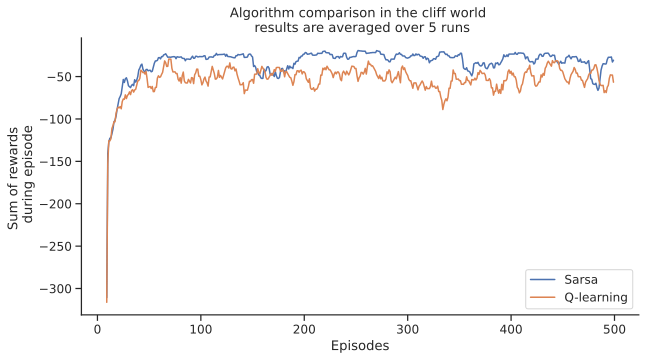

In [7]:
WINDOW_SIZE = 10

df_rewards = pd.DataFrame(data=np.stack([rewards_sarsa.mean(axis=0), rewards_qlearning.mean(axis=0)]).T, columns=['Sarsa', 'Q-learning'])
df_rewards.rolling(window=WINDOW_SIZE).mean().plot(title=f'Algorithm comparison in the cliff world \n results are averaged over {num_runs} runs')
plt.xlabel('Episodes')
plt.ylabel(f'Sum of rewards \n during episode')
plt.legend()
#plt.ylim([-100, 0])
sns.despine()

In [8]:
# Let's visualize the best actios for every state! =]
Q_sarsa.style.apply(highlight_max, props='color:blue;', axis=1)

,Left,Right,Up,Down
"(0, 0)",-27.851880,-27.522309,-27.309485,-27.331070
"(0, 1)",-27.149816,-26.854887,-26.872433,-27.245285
"(0, 2)",-26.167254,-26.489475,-24.060925,-26.722738
"(0, 3)",-26.910200,-26.326383,-23.304835,-25.959913
"(0, 4)",-17.042849,-21.404723,-13.751683,-21.652764
"(0, 5)",-19.153254,-20.565763,-10.815428,-16.866291
"(0, 6)",-16.748303,-19.125815,-8.526752,-17.080396
"(0, 7)",-13.739120,-17.261463,-7.326617,-16.481377
"(0, 8)",-10.618048,-19.265457,-6.225707,-19.445703
"(0, 9)",-9.560340,-14.416903,-5.325183,-15.326715


In [9]:
# Let's visualize the best actios for every state! =]
Q_learn.style.apply(highlight_max, props='color:orange;', axis=1)

,Left,Right,Up,Down
"(0, 0)",-12.500000,-12.955108,-12.536583,-12.500000
"(0, 1)",-11.962472,-11.974007,-11.766548,-12.651839
"(0, 2)",-10.971215,-11.365570,-11.014791,-11.947073
"(0, 3)",-10.329256,-10.415708,-10.141690,-11.451758
"(0, 4)",-9.840213,-9.558934,-9.320956,-9.814146
"(0, 5)",-9.014470,-8.798741,-8.509218,-9.012859
"(0, 6)",-8.056539,-7.763525,-7.634935,-7.652489
"(0, 7)",-7.197144,-6.757082,-6.770792,-7.277907
"(0, 8)",-6.000000,-5.910335,-5.832250,-6.705130
"(0, 9)",-4.912777,-4.952313,-4.911214,-5.288136
